# IMPORT

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix
import graphviz

# Tải dataset Forest Type Mapping từ UCI

In [16]:
df = pd.read_csv('Forest_Type_Mapping.csv')

# Tách dữ liệu và nhãn

In [17]:
X = df.drop(columns=['class'])
y = df['class']

# Chọn chia dữ liệu train/test (ví dụ 80% train, 20% test) với stratify và shuffle

In [18]:
test_size_options = [0.1, 0.2, 0.2, 0.4, 0.6]
test_size = 0
is_max_depth_experiment = False

print("#1 train/test = 90/10")
print("#2 train/test = 80/20")
print("#3 train/test = 80/20 (with max_depth experiment)")
print("#4 train/test = 60/40")
print("#5 train/test = 40/60")

pick = int(input("Pick a proportion (1-5): #"))
test_size = test_size_options[pick - 1]

max_depth_text, is_max_depth_experiment = ("(with max_depth experiment)", True) if pick == 3 else ("", False)

print(f"-> train/test = {100 - int(test_size*100)}/{int(test_size*100)} {max_depth_text}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42
)

#1 train/test = 90/10
#2 train/test = 80/20
#3 train/test = 80/20 (with max_depth experiment)
#4 train/test = 60/40
#5 train/test = 40/60


Pick a proportion (1-5): # 3


-> train/test = 80/20 (with max_depth experiment)


# Huấn luyện Decision Tree (dùng information gain → criterion="entropy")

In [19]:
def train_decision_tree(max_depth):
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    return clf

# Dự đoán trên tập test

In [20]:
def y_predicts(clf, X_test):
    return clf.predict(X_test)

# Các hàm báo cáo đánh giá mô hình

## Hàm xuất classification report và confusion matrix

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Classification report -----------------------------------------------------------------------------------------
def print_classification_report(y_test, y_pred, target_names):
    print("Classification Report:")
    report = classification_report(y_test, y_pred, target_names=target_names)
    print(report)

# Confusion matrix ----------------------------------------------------------------------------------------------
def draw_confusion_matrix(y_test, y_pred, target_names, class_labels):
    # Lấy tất cả các lớp có trong y_test và y_pred
    all_labels = np.union1d(y_test, y_pred)  # Tìm tất cả lớp có trong y_test và y_pred
    
    # Cập nhật class_labels và target_names để bao gồm tất cả các lớp
    available_labels = [label for label in all_labels if label in class_labels]
    
    # Tạo confusion matrix với tất cả các lớp
    cm = confusion_matrix(y_test, y_pred, labels=all_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap="Blues", values_format='d')

    # 👉 Thay đổi nhãn trục x và y để xuống dòng
    ax.set_xticklabels([str(label).replace(" ", "\n") for label in target_names], rotation=0)
    ax.set_yticklabels([str(label).replace(" ", "\n") for label in target_names], rotation=0)

    # Cải thiện hiển thị
    ax.set_ylabel("True label", labelpad=15)
    ax.set_xlabel("Predicted label", labelpad=15)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.tight_layout()  # Đảm bảo các nhãn không bị cắt
    plt.show()

## Hàm vẽ cây

In [22]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

# Xuất cây quyết định thành dữ liệu .dot
def draw_decision_tree(clf):
    dot_data = export_graphviz(
        clf,
        out_file=None,
        feature_names=X.columns,
        class_names=[str(c) for c in clf.classes_],
        filled=True,
        rounded=True,
        special_characters=True,
        # Chỉ định font cho cây quyết định
        fontname="Arial"
    )
    # Cố gắng chỉ định font hợp lệ trong Matplotlib
    plt.rcParams["font.family"] = "Arial"  # Hoặc thử "Times New Roman" hoặc font nào đó có sẵn trên hệ thống của bạn

    # Tạo đồ thị từ dữ liệu .dot
    graph = pydotplus.graph_from_dot_data(dot_data)
    
    # Hiển thị cây dưới dạng hình PNG
    display(Image(graph.create_png()))

## Các hàm đánh giá thí nghiệm Max Depth

In [23]:
from IPython.display import display, Markdown
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

def accuracy_statistics(max_depth_options, accuracy_scores):
    col_names = ["None" if x is None else x for x in max_depth_options]
    
    # Tạo DataFrame
    df = pd.DataFrame([accuracy_scores], columns=col_names).round(4)
    
    # Đặt tên cho dòng và cột
    df.index = ["Accuracy"]
    df.columns.name = "max_depth"
    
    # Hiển thị
    display(df)

def accuracy_chart(max_depth_options, accuracy_scores):
    # Map max_depth_options: None => -1 (chỉ để vẽ), giữ lại label
    plot_x = [-1 if v is None else v for v in max_depth_options]
    
    plt.figure(figsize=(8, 6))
    plt.plot(plot_x, accuracy_scores, marker='o', linestyle='-', color='b')
    
    # Thêm tiêu đề và nhãn
    plt.title('Accuracy vs Max Depth', fontsize=14)
    plt.xlabel('Max Depth', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    
    # Gán nhãn trục x theo max_depth_options gốc
    plt.xticks(plot_x, labels=[str(v) if v is not None else "None" for v in max_depth_options])
    
    plt.grid(True)
    plt.show()

# Output

In [24]:
# Các label và tên class tương ứng
class_labels = ["s", "h", "d", "o"]
target_names = ["Sugi Forest", "Hinoki Forest", "Mixed deciduous Forest", "Other non-forest land"]

max_depth,None,2,3,4,5,6,7
Accuracy,0.8615,0.8923,0.8923,0.8308,0.8,0.8308,0.8462


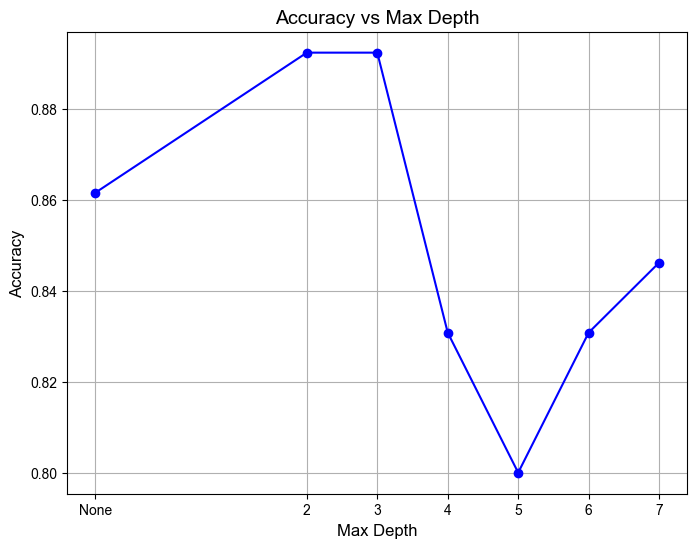

In [25]:
if is_max_depth_experiment:
    max_depth_options = [None, 2, 3, 4, 5, 6, 7]
    clf_containers = []
    accuracy_scores = []

    
    for max_depth in max_depth_options:
        clf = train_decision_tree(max_depth)
        clf_containers.append(clf)
        accuracy_scores.append(accuracy_score(y_test, y_predicts(clf, X_test)))
    accuracy_statistics(max_depth_options, accuracy_scores)
    accuracy_chart(max_depth_options, accuracy_scores)   
else:
    max_depth = None
    clf = train_decision_tree(max_depth)
    y_pred = y_predicts(clf, X_test)
    
    print_classification_report(y_test, y_pred, target_names)
    display(Markdown("---"))
    
    draw_confusion_matrix(y_test, y_pred, target_names, class_labels)   
    display(Markdown("---"))

    display(Markdown(f"## 🌲 Decision Tree:"))
    draw_decision_tree(clf)